# 1. Data

In [1]:
using CSV
using DataFrames
using ForwardDiff
using LinearAlgebra
using Optim

using Random
using Statistics
using Plots
using StatsPlots
using Distributions

using QuadGK

using FixedEffectModels
using RegressionTables

In [21]:
# Load raw data
df = DataFrame()
df = CSV.read("ps3clean.csv", DataFrame)

# Remove row with missing values (removes 1 row)
df = df[completecases(df), :]

# Remove spaces from names
names_no_space = filter.(x -> !isspace(x), names(df))
rename!(df, names_no_space)

,DataNuEer,bidder,house,date,lot,profit,NetPayment,rank,realisationinfinalauAtion
,Int64,Int64,String,Int64,String,Float64,Float64,Int64,Int64
1,1,1,A,35360,217,150.0,-150.0,1,5200
2,2,2,A,35360,217,150.0,150.0,2,5200
3,3,1,A,35360,218,0.0,0.0,1,1000
4,4,1,A,35360,220,0.0,0.0,1,1500
5,5,1,A,35360,222,0.0,0.0,1,4800
6,6,1,A,35360,350,0.0,0.0,1,2200
7,7,2,A,35360,350,0.0,0.0,2,2200
8,8,3,A,35360,350,0.0,0.0,3,2200
9,9,1,A,35360,351,0.0,0.0,1,1400


In [22]:
# println(names(df))

# Make unique lot identifier
df."unique_lot" = string.(df[:,"house"], df[:, "lot"], df[:, "date"], df[:, "realisationinfinalauAtion"])

2635-element Array{String,1}:
 "A217353605200"
 "A217353605200"
 "A218353601000"
 "A220353601500"
 "A222353604800"
 "A350353602200"
 "A350353602200"
 "A350353602200"
 "A351353601400"
 "A35235360200"
 "A35335360420"
 "A35335360420"
 "A35335360420"
 ⋮
 "F11182355002800"
 "F11182355002800"
 "F1118335500375"
 "F1118335500375"
 "F1118335500375"
 "F1118335500375"
 "F11184355003750"
 "F11184355003750"
 "F11184355003750"
 "F11184355003750"
 "F11184355003750"
 "F11184355003750"

In [23]:
# Initialize number of bidders in ring to dataframe
df."num_bidders" = zeros(size(df,1))

# Get number of bidders by counting within each lot
for i in 1:size(df,1)
    # Get lot
    u = df[i,"unique_lot"]
    
    # Number of participants
    df[i, "num_bidders"] = size(df[isequal.(df."unique_lot", u), :], 1)
end

In [25]:
# Initialize Table 1
table_1 = DataFrame(House = [], 
    Target_m = [], Target_sd = [],
    Knock_m = [], Knock_sd = [],
    Percent_won = [], Percent_val_won = [],
    Total_lots = []
)

# Get houses
hs = unique(df."house")

# Initialize aggregate wins and value
tot_wins = 0
tot_value_win = 0

# Initialize aggregate lots and their value
tot_lots = 0
tot_value_lots = (sum(df."EstDatedMaxDum") + sum(df."EstDatedMinDum"))/2

# Build stats for each house
for h in hs
    
    # Get house subset
    d = df[isequal.(df."house", h), :]
    
    # Subset of knockout winners
    dt = d[isequal.(d."rank",1), :]
    
    # Get target auction mean and sd
    tar_m = mean(dt."realisationinfinalauAtion")
    tar_sd = std(dt."realisationinfinalauAtion")
    
    # Get knockout mean and sd
    kn_m = mean(d."bid")
    kn_sd = std(d."bid")
    
    # Initialize house wins and value won
    wins = 0
    value_win = 0
    
    # Count wins and their value
    for i in 1:size(dt,1)
        if dt[i,"bid"] >= dt[i, "realisationinfinalauAtion"]
            wins += 1
            tot_wins += 1
            value_win += (dt[i, "EstDatedMaxDum"] + dt[i, "EstDatedMinDum"])/2
            tot_value_win += (dt[i, "EstDatedMaxDum"] + dt[i, "EstDatedMinDum"])/2
        end
    end
    
    # Get lots in house
    lots = length(unique(d."unique_lot"))
    
    # Add to total
    tot_lots += lots
    value_lots = (sum(dt."EstDatedMaxDum") + sum(dt."EstDatedMinDum"))/2
    
    # Get percentages
    per_won = wins/lots
    per_val = value_win/value_lots
    
    # Add to table
    push!(table_1, [h, tar_m, tar_sd, kn_m, kn_sd, per_won, per_val, lots])
    
end

# Get knockout winners for all auctions
dt_all = df[isequal.(df."rank",1), :]

# Add aggregate row
push!(table_1, ["Agg", 
        mean(dt_all."realisationinfinalauAtion"), std(dt_all."realisationinfinalauAtion"),
        mean(df."bid"), std(df."bid"),
        tot_wins/tot_lots, tot_value_win/tot_value_lots,
        tot_lots])

table_1

,House,Target_m,Target_sd,Knock_m,Knock_sd,Percent_won,Percent_val_won,Total_lots
,Any,Any,Any,Any,Any,Any,Any,Any
1,A,1633.45,1692.0,1111.54,1560.45,0.275862,0.475484,29
2,B,1000.32,1454.49,1330.36,2756.7,0.648649,0.762799,37
3,C,951.08,1585.72,1384.83,2270.48,0.628641,0.812041,412
4,D,1083.99,1402.05,1326.64,1757.03,0.457516,0.766882,153
5,E,2904.02,3057.48,4219.53,4825.89,0.866142,0.882836,127
6,F1,1618.6,2562.45,1941.04,3706.33,0.48,0.653065,100
7,Agg,1366.84,2081.6,2106.72,3423.48,0.604895,0.18629,858


In [27]:
# Initialize Table 2
table_2 = DataFrame(Num_bidders = [], 
    Target_m = [], Target_sd = [],
    Knock_m = [], Knock_sd = [],
    Percent_won = [], Total_lots = []
)

# Get number of bidders set (and sort)
ns = sort(unique(df."num_bidders"))

# For each number of bidder set
for n in ns
    # Get subset
    d = df[isequal.(df."num_bidders", n), :]
    
    # Get wins
    dt = d[isequal.(d."rank",1), :]
    
    # Get target auction mean and sd
    tar_m = mean(dt."realisationinfinalauAtion")
    tar_sd = std(dt."realisationinfinalauAtion")
    
    # Get knockout mean and sd
    kn_m = mean(d."bid")
    kn_sd = std(d."bid")
    
    # Initialize wins
    wins = 0
    
    # Get win count
    for i in 1:size(dt,1)
        if dt[i,"bid"] >= dt[i, "realisationinfinalauAtion"]
            wins += 1
        end
    end
    
    # Get number of lots
    lots = length(unique(d."unique_lot"))
    
    # Get percentage won
    per_won = wins/lots
    
    # Add to table
    push!(table_2, [n, tar_m, tar_sd, kn_m, kn_sd, per_won, lots])
    
end

table_2

,Num_bidders,Target_m,Target_sd,Knock_m,Knock_sd,Percent_won,Total_lots
,Any,Any,Any,Any,Any,Any,Any
1,1.0,568.271,863.261,498.481,900.042,0.285714,266.0
2,2.0,990.819,1803.2,946.208,2799.54,0.590604,149.0
3,3.0,1221.42,1512.19,1082.78,1605.29,0.677165,127.0
4,4.0,2029.59,2824.86,2185.52,4351.71,0.772727,110.0
5,5.0,1754.94,2331.02,1861.33,3157.45,0.835443,79.0
6,6.0,2327.45,3144.88,2643.12,3934.17,0.890909,55.0
7,7.0,2722.16,2052.97,3447.77,2971.75,0.960784,51.0
8,8.0,4290.48,2555.56,5500.92,4009.06,0.952381,21.0


# 2: Introductory Questions

Some quick and rough responses, to be refined later.

## 1

The bids are biased upwards because of the possibility of a side-payment reward for bidding more than your value and still losing. For example, if my valuation for an item is 5, but I am confidend that a few of the other ring members will bid 10, I am ahead to bid 9, so that if the item sells for 7, say, then I am better off, since bidding my value gives 0, but bidding 9 gives me some portion of the increment from 7 to 9. In effect, I have pretended to value the item more than I do, so my ring members have paid me a side payment accordingly.

## 2

### (a)

Maps from bids and bid distributions to valuations

### (b)

$v(b)$ may be non-monotonic, in which case some of the critical points may be minima instead of maxima.

### (c)

We assume (2) is strictly monotonic.

## 3

Lack of identification for $3+$ bidders

## 4

Seller/auctioneer - Ambiguous. There is overbidding from the knockout auction, which may increase the sale price, but when the ring wins an item, it is possible that its members would have bid the price higher, if not for the knockout.

Non-ring bidder: Hurt. The ring may win at a price higher than its valuation, in which case the non-ring bidder would have won if not for the ring. The ring may also lose, but due to overbidding have bid up the price higher than if the ring were not present.

Ring members: Ambiguous. They will be better off in cases where they would win the item, and no one outside the ring bids much, hence the item sells lower than it would without the ring, and the winner is better off, even after side-payments. Members may also be better off because they can recoup side-payments for lots which end up selling lower than their valuation, but only due to the ring (this is something for nothing). The case where they will be worse off, however, is when they overbid and then must follow through, paying more than their valuation for the item.


In [7]:
# Initialize Table 5
table_5 = DataFrame(Ring_member = [], 
    per_high_1 = [], num_kn_1 = [],
    per_high_2 = [], rec_sp = [],
    pay_sp = [], num_kn_2 = []
)

# Get set of bidders (and sort)
bs = sort(unique(df."bidder"))

# Entry for each bidder
for b in bs
    
    # Get bidder
    d1 = df[isequal.(df."bidder", b), :]
    
    # Knockout wins
    count_high_1 = size(d1[isequal.(d1."rank", 1), :], 1)
    
    # Knockout participation
    count_1 = size(d1,1)
    
    # Subset with >= 2 bidders
    d2 = d1[d1."num_bidders" .>= 2, :]
    
    # Knockout wins
    count_high_2 = size(d2[isequal.(d2."rank", 1), :], 1)
    
    # Knockout participation
    count_2 = size(d2,1)
    
    # Count receive payment
    rec_sp = size(d2[d2."NetPayment" .> 0, :], 1)
    
    # Count make payment
    pay_sp = size(d2[d2."NetPayment" .< 0, :], 1)
    
    # Add to table
    push!(table_5, [b, count_high_1/count_1, count_1, 
            count_high_2/count_2, rec_sp/count_2, pay_sp/count_2, count_2])
end

table_5

,Ring_member,per_high_1,num_kn_1,per_high_2,rec_sp,pay_sp,num_kn_2
,Any,Any,Any,Any,Any,Any,Any
1,1.0,0.398773,652.0,0.241779,0.232108,0.0773694,517.0
2,2.0,0.0966851,362.0,0.0840336,0.235294,0.0196078,357.0
3,3.0,0.374046,393.0,0.274336,0.286136,0.100295,339.0
4,4.0,0.272446,323.0,0.261006,0.286164,0.13522,318.0
5,5.0,0.375465,269.0,0.232877,0.242009,0.0593607,219.0
6,6.0,0.464052,153.0,0.460526,0.144737,0.197368,152.0
7,7.0,0.413793,232.0,0.400881,0.259912,0.242291,227.0
8,8.0,0.166667,30.0,0.0384615,0.346154,0.0,26.0
9,9.0,0.480519,77.0,0.452055,0.287671,0.164384,73.0


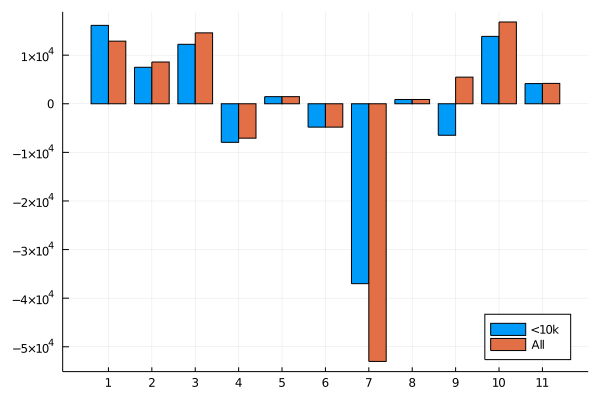

In [8]:
# Initialize sidepayments
sps = zeros(length(bs),2)

# Find for each bidder
for b in bs
    # Get bidder subset
    d = df[isequal.(df."bidder", b), :]
    
    # Get net payments
    sp = sum(d."NetPayment")
    
    # Get net payments where target price < 10,000
    sp_10k = sum(d."NetPayment" .* (d."realisationinfinalauAtion" .< 10000))
    
    # Add to sidepayments
    sps[b,:] = [sp, sp_10k]
end

# Make bar chart
groupedbar(sps, xticks = (1:length(bs), bs), group = repeat(["All", "<10k"], 
        inner = length(bs)), legend = :bottomright)

In [9]:
# Filter out auctions with more than s(=2) ring bidders
s = 2
df = df[df."num_bidders" .<= s, :]

,DataNuEer,bidder,house,date,lot,profit,NetPayment,rank,realisationinfinalauAtion
,Int64,Int64,String,Int64,String,Float64,Float64,Int64,Int64
1,1,1,A,35360,217,150.0,-150.0,1,5200
2,2,2,A,35360,217,150.0,150.0,2,5200
3,3,1,A,35360,218,0.0,0.0,1,1000
4,4,1,A,35360,220,0.0,0.0,1,1500
5,5,1,A,35360,222,0.0,0.0,1,4800
6,9,1,A,35360,351,0.0,0.0,1,1400
7,10,1,A,35360,352,0.0,0.0,1,200
8,14,2,A,35360,354,0.0,0.0,1,130
9,21,1,A,35360,358,0.0,0.0,1,850


In [10]:
# Get unique lots
us = unique(df."unique_lot")

# Create log of bids variables
df."log_bid" = log.(df."bid")

# Create dataframe to be used for regression
df_b = copy(df)

# println("df 1: ", size(df))
# println("df_b 1: ", size(df_b))

# For each lot
for u in us
    # Get entries
    d = df[df."unique_lot" .== u, :]
    # Grab first entry (arbitrarily)
    di = d[1,:]
    # Replace bid by realization
    di."bid" = di."realisationinfinalauAtion"
    # Replace bidder by target (bidder 0)
    di."bidder" = 0
    
    # Add to data
    push!(df_b, di)
end

# println("df 2: ", size(df))
# println("df_b 2: ", size(df_b))

# println(names(df_b))

# Regress as in paper (I suppose)
r = reg(df_b, @formula(log_bid ~ EstDatedMinDum + EstDatedMaxDum + AatalogPriAe
        + GradeMin + GradeMax + ExAlusivelyUS + NoValue + fe(bidder)), 
    Vcov.robust(),
)

# Replace by normalized bids
df."bid" = exp.(df."log_bid" - convert(Matrix, df[:, ["EstDatedMinDum", "EstDatedMaxDum", "AatalogPriAe", 
        "GradeMin", "GradeMax", "ExAlusivelyUS", "NoValue"]])*coef(r))


Demean Variables: [================================>]  8/8

564-element Array{Float64,1}:
   67.2141230936741
   46.20970962690094
  489.35243670938405
  501.2411912045971
  279.69680200864633
  257.19652270567076
  224.1404295064278
   86.07128754983779
  191.97293173195422
  159.97744310996183
  234.10522852525534
 1453.2905363495404
 1089.9679022621553
    ⋮
  122.93172346217693
  424.5510903332743
  424.5510903332743
  179.96534992895658
  106.3431613216561
  315.94685739690885
  169.53246006663386
  409.3733694928384
  212.2676730703605
  322.07601449829934
  380.4464733065835
  363.9053222932539

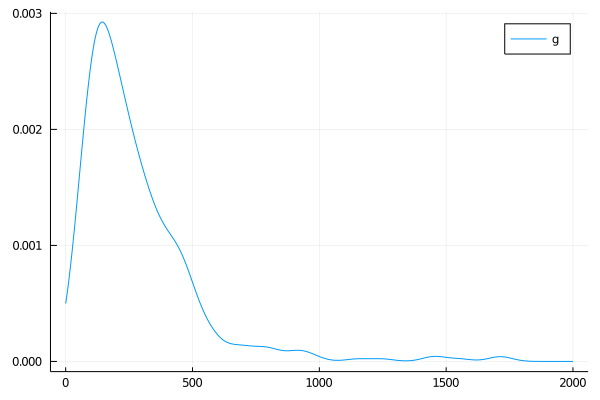

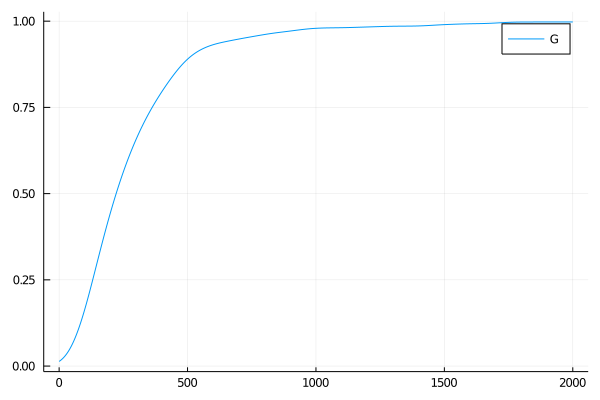

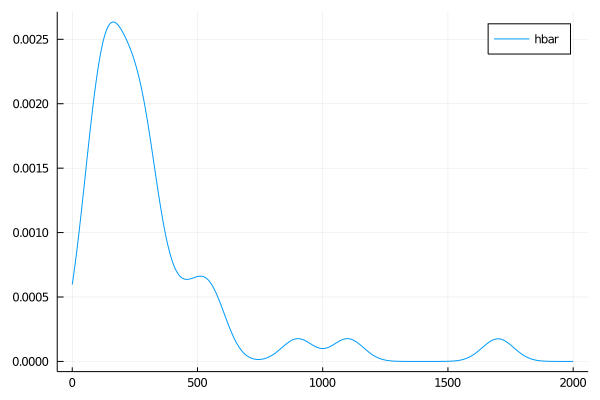

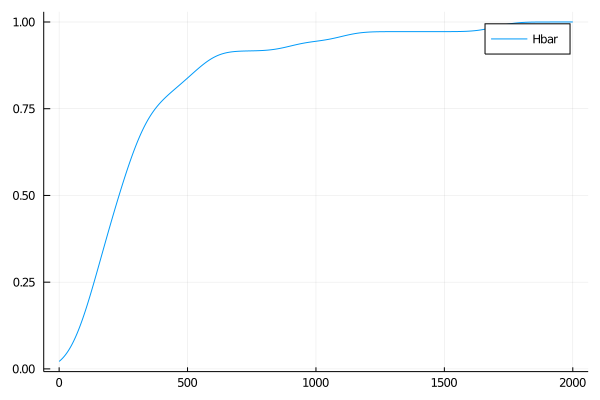

In [16]:
# From Wikipedia: https://en.wikipedia.org/wiki/Kernel_density_estimation
function silverman_bw(x)
    return 0.9*min(std(x), (quantile(x,0.75) - quantile(x,0.25))/1.34)*length(x)^(-1/5)
end

# KDE of pdf, where x is data, z is arg, and K is kernel
function kernel_pdf(x, z, K)
    h = silverman_bw(x)
    return 1/(length(x)*h)*sum([pdf(K,(z-xi)/h) for xi in x])
end

# KDE of cdf
function kernel_cdf(x, z, K)
    h = silverman_bw(x)
    return 1/(length(x))*sum([cdf(K,(z-xi)/h) for xi in x])
end

# Get subset of knockout winners
dhigh = df[df."rank" .== 1, :]
# Get knockout winning bids
ms = sort(dhigh."bid")

# Get subset where ring wins item
dh = dhigh[dhigh."realisationinfinalauAtion" .< dhigh."bid",:]
# Get winning bid (this is "outside ring" valuation)
rs = sort(dh."realisationinfinalauAtion")


# Args for functions
zs = LinRange(0,2000,2000)

# density g
pg = plot(zs, [kernel_pdf(ms, z, Normal()) for z in zs], label = "g")
display(pg)

# dist G
pG = plot(zs, [kernel_cdf(ms, z, Normal()) for z in zs], label = "G")
display(pG)

# density h
phbar = plot(zs, [kernel_pdf(rs, z, Normal()) for z in zs], label = "hbar")
display(phbar)

# dist H
pHbar = plot(zs, [kernel_cdf(rs, z, Normal()) for z in zs], label = "Hbar")
display(pHbar)

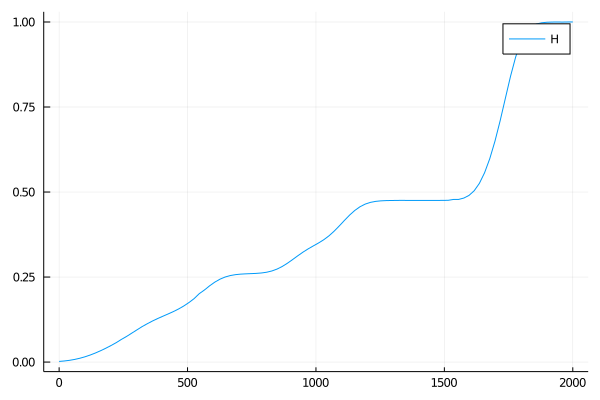

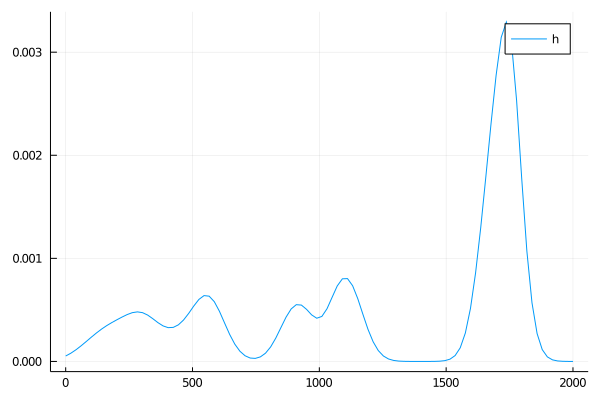

In [12]:
# H dist, where hx is data used for calculating h, gx is data for G, 
# r is arg, K is kernel, ub is upper bound for denom estimation
function H(hx,gx,r,K,ub)
    # Get hbar
    hbar(z) = kernel_pdf(hx,z,K)
    
    # Get G
    G(z) = kernel_cdf(gx,z,K)
    
    # Constuct integrand
    int_term(z) = hbar(z)/(1-G(z))
    
    # denominator (full integral)
    denom = quadgk(int_term, -Inf, ub, rtol=1e-5)[1]
    
    # numerator is partial integral
    return quadgk(int_term, -Inf, r, rtol=1e-3)[1] / denom
end

# h density, (see above for arguments)
function h(hx,gx,r,K,ub)
    # Get hbar
    hbar(z) = kernel_pdf(hx,z,K)
    
    # Get G
    G(z) = kernel_cdf(gx,z,K)
    
    # Construct integrand
    int_term(z) = hbar(z)/(1-G(z))
    
    # numerator is just integrand
    return int_term(r)/(quadgk(int_term, -Inf, ub, rtol=1e-5)[1])
end

# Test
# upper bound
ub = 2000
# Number of sample points
N = 100
# Sample points
zs = LinRange(0,ub,N)
# Plot H
pH = plot(zs, [H(rs, ms, z, Normal(),ub) for z in zs], label = "H")
display(pH)
# Plot h
ph = plot(zs, [h(rs, ms, z, Normal(),ub) for z in zs], label = "h")
display(ph)


In [13]:
# Get set of bidders (again)
bs = sort(unique(df."bidder"))

# Initialize bid pdfs, cdfs, and prob. of participation
bid_pdfs = []
bid_cdfs = []
alphas = []

# Find for each bidder
for b in bs
    # Get bidder subset
    d = df[isequal.(df."bidder", b), :]
    # Get bids
    bids = d."bid"
    # Build pdf
    kp(z) = kernel_pdf(bids, z, Normal())
    
#     p = plot(zs, [kp(z) for z in zs], label = string(b, " kp"))
#     display(p)
    
    # Add to list
    push!(bid_pdfs, kp)
    
    # Build cdf
    kc(z) = kernel_cdf(bids, z, Normal())
    
#     p = plot(zs, [kc(z) for z in zs], label = string(b, " kc"))
#     display(p)
    
    # Add to list
    push!(bid_cdfs, kc)
    
    # Number of particpated/number of lots
    push!(alphas, size(df[isequal.(df."bidder", b), :],1)/size(unique(df."unique_lot"),1))
    
end

# Initialize the "_{-i}" pdfs, cdfs
bid_neg_pdfs = []
bid_neg_cdfs = []

# For each bidder
for b in bs
    
    # Get set of other bidders
    nbs = filter(z -> (z != b), bs)
    
    # Get density of other bids
    kpn(z) = sum([alphas[nb]*bid_pdfs[nb](z) for nb in nbs])/sum([alphas[nb] for nb in nbs])
    
#     p = plot(zs, [kpn(z) for z in zs], label = string(b, " kpn"))
#     display(p)
    
    # Add to pdf list
    push!(bid_neg_pdfs, kpn)
    
    # Get dist of other bids
    kcn(z) = sum([alphas[nb]*bid_cdfs[nb](z) for nb in nbs])/sum([alphas[nb] for nb in nbs])
    
#     p = plot(zs, [kcn(z) for z in zs], label = string(b, " kcn"))
#     display(p)
    
    # Add to cdf list
    push!(bid_neg_cdfs, kcn)
    
end


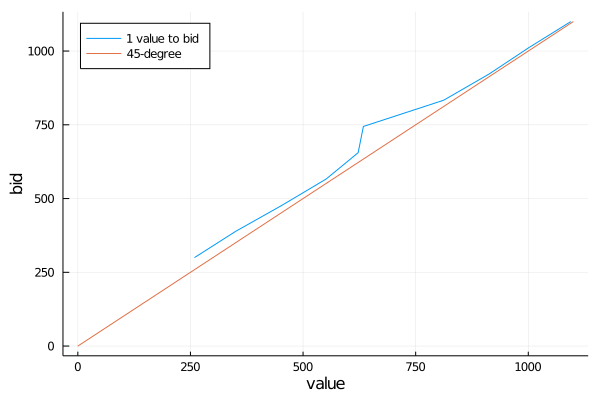

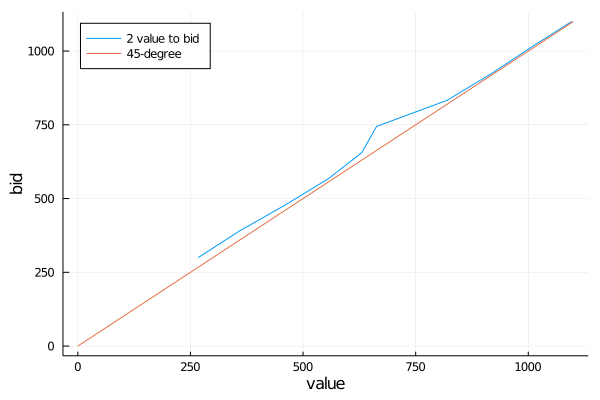

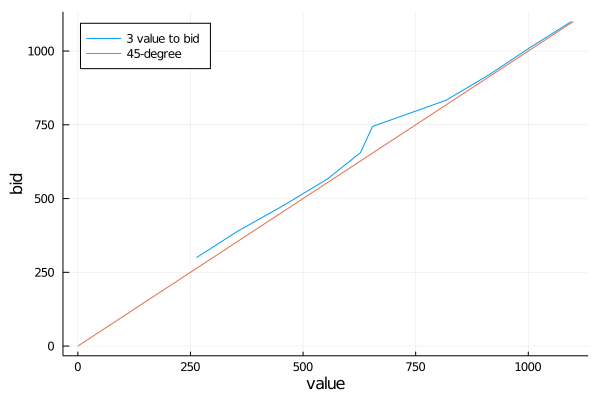

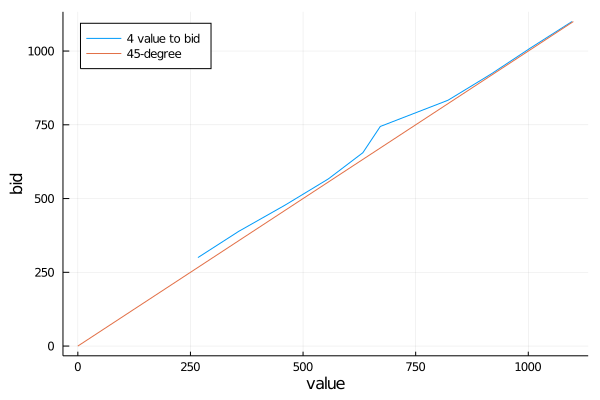

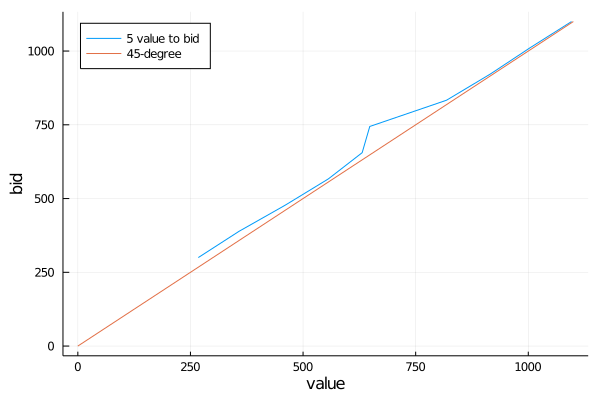

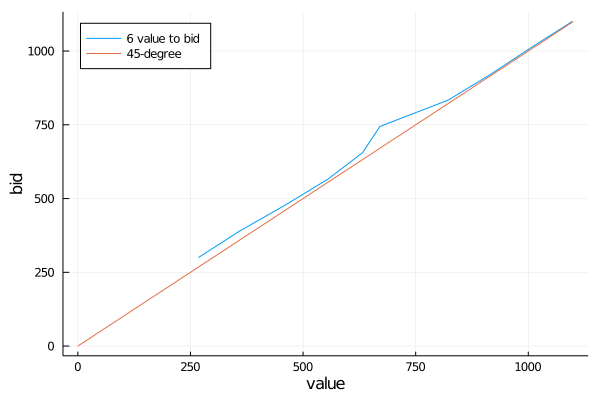

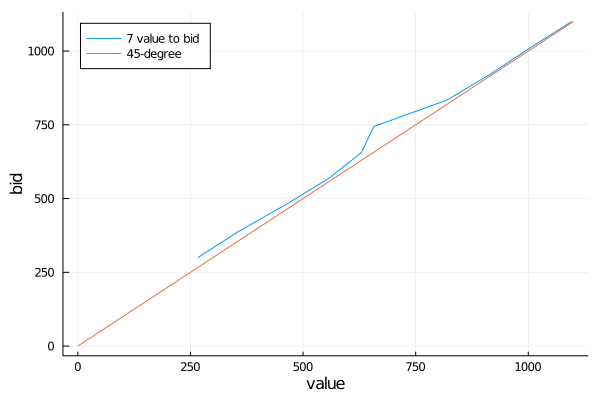

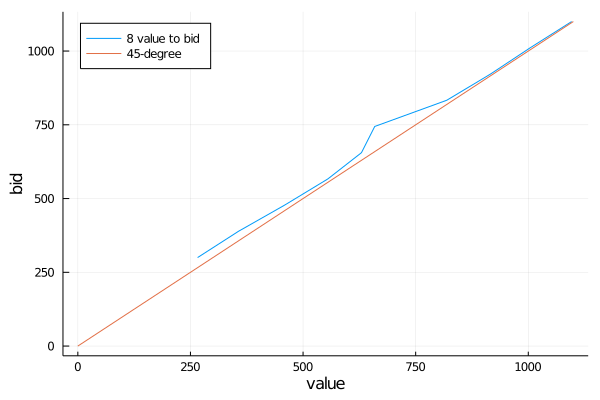

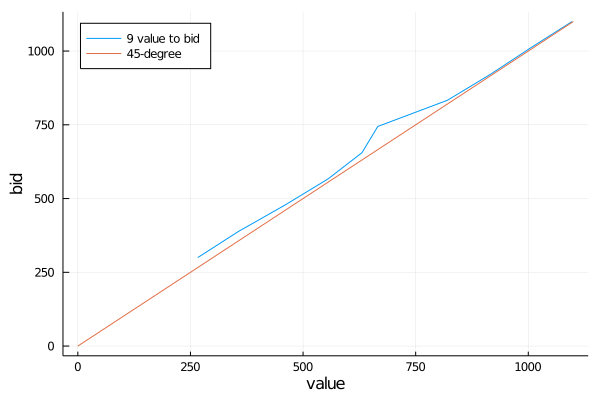

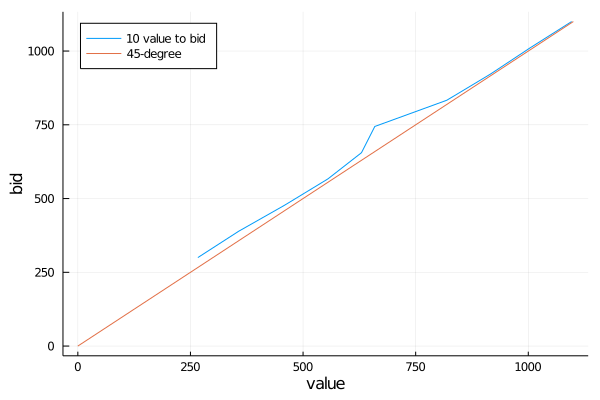

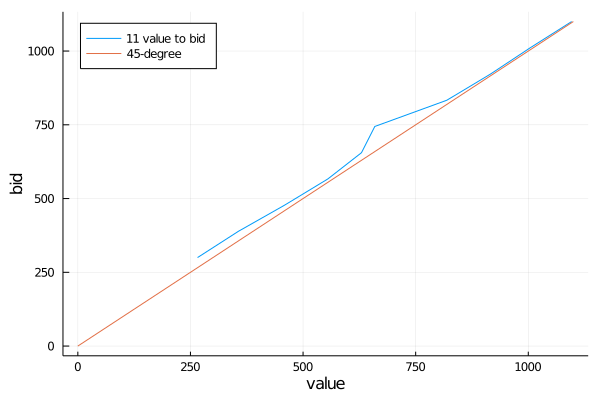

In [20]:
# Equation 2, maps bids to valuations
function eq2(b, H, h, G_neg, g_neg)
    return b - 1/2*(H(b)*(1 - G_neg(b)))/(h(b)*G_neg(b) + H(b)*g_neg(b))
end

# Bound for denom integrals
temp_ub = 2000

# bid range
zs = LinRange(300,1100,10)

# 45-degree range
zs45 = LinRange(0,1100, 10)

# For each bidder make Fig 2
for b in bs
    # Build functions needed
    tempH(z) = H(rs,ms,z,Normal(),temp_ub)
    temph(z) = h(rs,ms,z,Normal(),temp_ub)
    tempG_neg(z) = bid_neg_cdfs[b](z)
    tempg_neg(z) = bid_neg_pdfs[b](z)
    
    # Plot bid function
    p = plot([eq2(z, tempH, temph, tempG_neg, tempg_neg) for z in zs], zs, 
        label = string(b, " value to bid"), xlabel = "value", ylabel = "bid", legend = :topleft)
    
    # Add 45-degree line
    plot!(zs45, zs45, label = "45-degree")
    display(p)
end

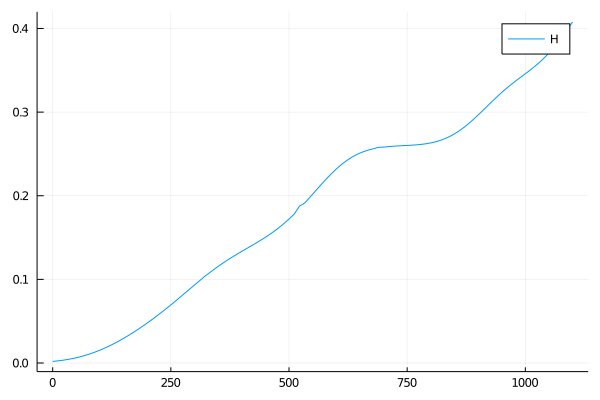

In [15]:
# Args
zs = LinRange(0,1100, 100)

# Upper boudn for denom
ub = 2000

# Plots bottom of Fig 2
pH = plot(zs, [H(rs, ms, z, Normal(),ub) for z in zs], label = "H")
display(pH)